In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import util as u
import text_processing as tp
%load_ext autoreload
%autoreload 2

from gensim import corpora, models, similarities, matutils # make this more specific
from gensim.corpora.dictionary import Dictionary
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from gensim.corpora import TextCorpus

In [20]:
# from sklearn.cluster import KMeans

### Load the GloVe word-embeddings model & convert to word2vec format

In [6]:
glove_file = 'Data/glove.twitter.27B.200d.txt'
tmp_file = 'glove_twitter_w2v.txt'
glove2word2vec(glove_file, tmp_file)

(1193514, 200)

In [7]:
# this takes a while
model = KeyedVectors.load_word2vec_format(tmp_file)

### Load the lyrics data

In [2]:
# df, lyrics = u.load_lyrics_data()
df = u.open_pkl('Data/all_lyrics_with_sim_df_9_topics.pkl')
dtm = u.open_pkl('Data/dtm_tf.pkl')

In [3]:
country_idx_start = np.min(list(df[df['Genre'] == 'country'].index))

In [4]:
df.head()

,ID,Song,Artist,Album,Genre,Lyrics,Median Most Sim Idx,Top 20 Most Sim,Cluster Labels 2 Cosine
0,Lucid Dreams - Juice WRLD,Lucid Dreams,Juice WRLD,JuiceWRLD 9 9 9,rap,"\n\n[Intro]\nEnviyon on the mix\nNo, no, no, n...",2085.5,"[1863, 2592, 2429, 1130, 1557, 2703, 1616, 112...",0
1,Better Now - Post Malone,Better Now,Post Malone,​beerbongs & bentleys,rap,\n\n[Chorus]\nYou prolly think that you are be...,759.0,"[558, 483, 659, 993, 857, 758, 769, 449, 862, ...",1
2,ZEZE - Kodak Black,ZEZE,Kodak Black,KB2,rap,\n\n[Intro]\nD.A. got that dope!\n\n[Chorus: T...,196.0,"[151, 124, 330, 165, 884, 130, 601, 362, 203, ...",1
3,Drip Too Hard - Lil Baby,Drip Too Hard,Lil Baby,Drip Harder,rap,"\n\n[Intro]\nRun that back, Turbo\n\n[Verse 1:...",446.0,"[413, 728, 935, 620, 617, 325, 535, 339, 732, ...",1
4,Mo Bamba - Sheck Wes,Mo Bamba,Sheck Wes,MUDBOY,rap,\n\n[Intro]\n16yrold\nBitch!\nDaytrip took it ...,424.0,"[198, 303, 23, 694, 716, 665, 671, 162, 425, 2...",1


### Compute word-embedding vectors for documents en masse

**1. Pre-process & tokenize text**. Will ignore n-grams

In [ ]:
df['Parsed'] = df['Lyrics'].apply(lambda x: tp.preproc_and_toke(x, model))

Check that we don't have any empty lists:

In [ ]:
parsed_lens = [len(x) for x in df['Parsed']]
np.min(parsed_lens)

In [241]:
df['Non-vocab Words'] = df['Lyrics'].apply(lambda x: tp.get_words_not_in_model_vocab(x, model))
missing_vocab = set(sum(df['Non-vocab Words'].values, []))
len(missing_vocab)

In [306]:
u.pkl_this('Data/missing_words.pkl', missing_vocab)

In [137]:
# if I need, though this code isn't working
# dictionary = corpora.Dictionary(df[['Parsed']].values)

**2. Compute document vectors**. Sum and Mean.

In [327]:
df['Doc Vect Sum'] = df['Parsed'].apply(lambda x: np.sum(model[x], axis=0))
df['Doc Vect Mean'] = df['Parsed'].apply(lambda x: np.mean(model[x], axis=0))

In [307]:
u.pkl_this('Data/all_lyrics_parsed_df.pkl', df)

## Cosine Similarity of word-embeddings vectors

In [123]:
compute = False

if compute:
    vect_sums = [x[0] for x in df[['Doc Vect Sum']].values]
    doc_sims_vect_sums = [model.cosine_similarities(x, vect_sums) for x in vect_sums]

    vect_means = [x[0] for x in df[['Doc Vect Mean']].values]
    doc_sims_vect_means = [model.cosine_similarities(x, vect_means) for x in vect_means]

    # u.pkl_this('Data/word_embedd_vect_sum_cos_sim.pkl', doc_sims_vect_sums)
    # u.pkl_this('Data/word_embedd_vect_mean_cos_sim.pkl', doc_sims_vect_means)
else:
    doc_sims_vect_sums = u.open_pkl('Data/word_embedd_vect_sum_cos_sim.pkl')
    doc_sims_vect_means = u.open_pkl('Data/word_embedd_vect_mean_cos_sim.pkl')

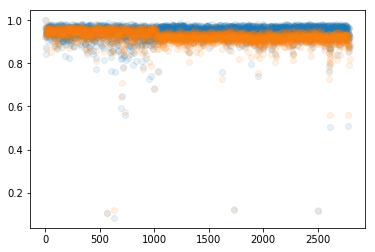

In [124]:
plt.plot(doc_sims_vect_sums[0], 'o', alpha=0.1)
plt.plot(doc_sims_vect_sums[10], 'o', alpha=0.1);

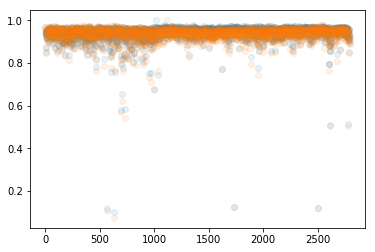

In [127]:
plt.plot(doc_sims_vect_sums[country_idx_start], 'o', alpha=0.1);
plt.plot(doc_sims_vect_sums[country_idx_start+100], 'o', alpha=0.1);

Using vector means yields similar results.

In [138]:
most_sim_idx = [np.median(np.argsort(-x)[1:21]) for x in doc_sims_vect_sums]

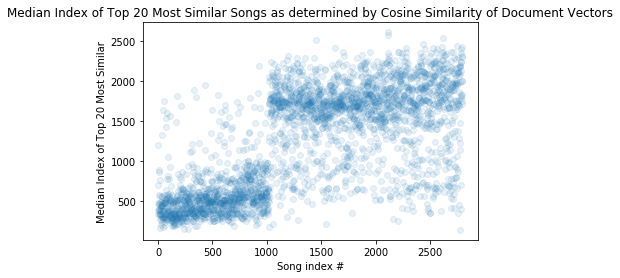

In [139]:
plt.plot(most_sim_idx, 'o', alpha=0.1)
plt.xlabel('Song index #')
plt.ylabel('Median Index of Top 20 Most Similar')
plt.title('Median Index of Top 20 Most Similar Songs as determined by Cosine Similarity of Document Vectors');

In [144]:
most_sim_idx_vm = [np.median(np.argsort(-x)[1:21]) for x in doc_sims_vect_means]

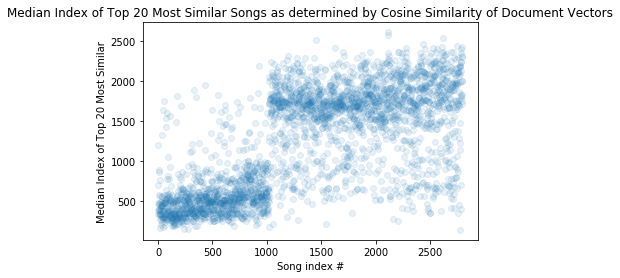

In [145]:
plt.plot(most_sim_idx_vm, 'o', alpha=0.1)
plt.xlabel('Song index #')
plt.ylabel('Median Index of Top 20 Most Similar')
plt.title('Median Index of Top 20 Most Similar Songs as determined by Cosine Similarity of Document Vectors');

In [148]:
# Standard Deviation of vector similarities (exepct to be high for highly-discriminating metric)
std_dev_sim = np.std(doc_sims_vect_sums, axis=0)
np.mean(std_dev_sim)

0.042689484

Compare to: 0.18993885624744303 for Hellinger Distance between 10-topic LDA feature vectors

In [142]:
df['Most Sim Idx CS-WE-VS'] = pd.Series(most_sim_idx)

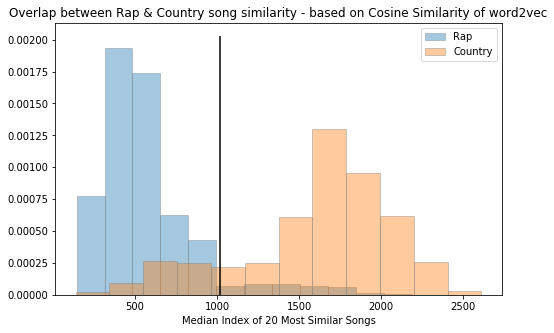

In [143]:
b = 12
plt.figure(figsize=(8,5))
plt.hist(df[df['Genre'] == 'rap']['Most Sim Idx CS-WE-VS'], density=True, alpha = 0.4, label='Rap',
        edgecolor='gray', linewidth=1, bins=b)
plt.hist(df[df['Genre'] == 'country']['Most Sim Idx CS-WE-VS'], density=True, alpha = 0.4, label='Country',
        edgecolor='gray', linewidth=1, bins=b)
plt.xlabel('Median Index of 20 Most Similar Songs')
# plt.ylabel('')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.legend()
plt.title(r"Overlap between Rap & Country song similarity - based on Cosine Similarity of word2vec")
plt.vlines(x=country_idx_start, ymin=0, ymax=ymax);

In [151]:
rap_df = df[df['Genre'] == 'rap']
cnty_df = df[df['Genre'] == 'country']

# compute percent of songs that are "mis-labeled"
rap_pct = (len(rap_df[rap_df['Most Sim Idx CS-WE-VS'] > country_idx_start]) / len(rap_df)) * 100 
cnty_pct = (len(cnty_df[cnty_df['Most Sim Idx CS-WE-VS'] < country_idx_start]) / len(cnty_df)) * 100

print("Using Cosine Distance of Word Embedding Vectors:")
print(f'Rap songs more similar to Country songs: {rap_pct: .2f}%') 
print(f'Country songs more similar to Rap songs: {cnty_pct: .2f}%') 

Using Cosine Distance of Word Embedding Vectors:
Rap songs more similar to Country songs:  6.38%
Country songs more similar to Rap songs:  14.30%


This metric "performs" better for rap songs than HD did, and worse for country songs. 

## Word Mover's Distance

As with other distance metrics, larger numbers = less similar

In [8]:
# u.pkl_this('Data/all_lyrics_parsed_df.pkl', df)
df = u.open_pkl('Data/all_lyrics_parsed_df.pkl')

In [9]:
model.init_sims(replace=True) # normalize the word-embedding vectors? or the document vectors?

`WMDSimilarity` computes WMD between parsed documents

In [45]:
wmd_corpus = np.ravel(df[['Parsed']].values)

In [48]:
from gensim.similarities import WmdSimilarity
num_best = 20
wdm_sim = WmdSimilarity(wmd_corpus, model, num_best=num_best)

In [68]:
# this was really slow
lyric = df.loc[9,'Parsed']
sims = wdm_sim[lyric]  # A query is simply a "look-up" in the similarity class.

KeyboardInterrupt: 

In [57]:
for i in range(num_best):
    print 
    print (f"{sims[i][1]: .4f} : {df.loc[sims[i][0], 'ID']} ({df.loc[sims[i][0], 'Genre']})")

 1.0000 : Sunflower - Post Malone (rap)
 0.5686 : All This Love - The Lost Trailers (country)
 0.5685 : Lovin' Lately - Big (country)
 0.5669 : Don't - Darius Rucker (country)
 0.5664 : Everything, Everyday, Everywhere - Fabolous (rap)
 0.5638 : Baby Don't Go - Fabolous (rap)
 0.5632 : Let Me Go - Christian Kane (country)
 0.5629 : Take It Out On Me - Florida Georgia Line (country)
 0.5621 : Stay - Florida Georgia Line (country)
 0.5611 : Stuck Like Glue - Sugarland (country)
 0.5611 : Grow Old - Florida Georgia Line (country)
 0.5610 : Somebody's Heartbreak - Hunter Hayes (country)
 0.5608 : Jump Then Fall - Taylor Swift (country)
 0.5599 : Do I - Luke Bryan (country)
 0.5597 : Didn't You Know How Much I Loved You - Kellie Pickler (country)
 0.5594 : Stay - Sugarland (country)
 0.5591 : Next To You - Mike Jones (rap)
 0.5591 : Don't - Billy Currington (country)
 0.5588 : You Can Get It All - Bow Wow (rap)
 0.5584 : Crazy Over Me - Dylan Scott (country)


In [64]:
# top 20 most similar based on cosine similarity of 10-topic LDA features
u.get_sim_songs(df, 9)

Similar songs for: Sunflower - Post Malone

Turnin' Me On - Blake Shelton (country)
Tequila - Dan + Shay (country)
Ho Hey - Lennon (country)
Either Way - Chris Stapleton (country)
Dayum, Baby - Florida Georgia Line (country)
See You Tonight - Scotty McCreery (country)
In Bloom - Sturgill Simpson (country)
All I Want For Christmas Is You - Whitney Duncan (country)
Lose It - Kane Brown (country)
Christmas All Over The World - Tim McGraw (country)
Here Tonight - Brett Young (country)
Work Hard, Play Harder - Gretchen Wilson (country)
Sangria - Blake Shelton (country)
All I Want For Christmas Is You - Lady Antebellum (country)
If He Ain't Gonna Love You - Jake Owen (country)
Doin' What She Likes - Blake Shelton (country)
Die A Happy Man - Thomas Rhett (country)
Baby, It's Cold Outside - Willie Nelson (country)
Look At You - Big (country)
Ronan - Taylor Swift (country)


With LDA, index #10 "behaved", in that it was more similar with rap songs than with country songs. Use it as a test case here:

In [ ]:
lyric = df.loc[10,'Parsed']
sims10 = wdm_sim[lyric]  # A query is simply a "look-up" in the similarity class.

In [70]:
for i in range(num_best):
    print 
    print (f"{sims10[i][1]: .4f} : {df.loc[sims10[i][0], 'ID']} ({df.loc[sims10[i][0], 'Genre']})")

 1.0000 : Nonstop - Drake (rap)
 0.5573 : Never Recover - Lil Baby (rap)
 0.5540 : Bad B*tch - French Montana (rap)
 0.5536 : All Me - Drake (rap)
 0.5520 : Seen It All - Jeezy (rap)
 0.5509 : 1942 Flows - Meek Mill (rap)
 0.5509 : Wins & Losses - Meek Mill (rap)
 0.5499 : Charged Up - Drake (rap)
 0.5496 : Do It - Mykko Montana (rap)
 0.5496 : Back To Back - Drake (rap)
 0.5492 : Look At Me Now - Chris Brown (rap)
 0.5489 : Digital Dash - Drake (rap)
 0.5487 : 0 To 100 / The Catch Up - Drake (rap)
 0.5468 : Ayy Ladies - Travis Porter (rap)
 0.5465 : First Day Out - Tee Grizzley (rap)
 0.5463 : Lighters - Bad Meets Evil (rap)
 0.5461 : Baby - LL Cool J (rap)
 0.5459 : 1985 - J. Cole (rap)
 0.5459 : Used To - Drake (rap)
 0.5459 : Sicko Mode - Travis Scott (rap)


In [71]:
# Create a new instance of `WmdSimilarity`, to compute WMD for all other docs
wdm_sim_all = WmdSimilarity(wmd_corpus, model, num_best=len(df))

In [74]:
sims10_all = wdm_sim_all[lyric]

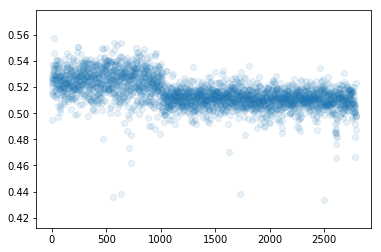

In [152]:
x,y = zip(*sims10_all)
plt.scatter(x[1:], y[1:], alpha=0.1);

This is "backwards" from what we'd expect: We expect lower distance / higher similarity between song index #10 (a rap song) and other rap songs (index < ~1000) than country songs (index > ~1000)

In [154]:
len(rap_df), len(cnty_df)

(1019, 1776)

In [155]:
df['Genre'].value_counts(1) * 

country    0.63542
rap        0.36458
Name: Genre, dtype: float64

In [166]:
rand_rap_idxs = np.random.randint(1, country_idx_start, size=36)
rand_cnty_idxs = np.random.randint(country_idx_start, len(df), size=64)
rand_idxs = np.concatenate((rand_rap_idxs, rand_cnty_idxs))

In [168]:
rand_sims_all = [] 
for i in rand_idxs:
    lyric = df.loc[i,'Parsed']
    rand_sims_all.append(wdm_sim_all[lyric])

KeyboardInterrupt: 

In [170]:
len(rand_sims_all)

9

## Other distance metrics

In [121]:
from gensim.matutils import kullback_leibler, jaccard, hellinger, sparse2full